# Long Short Term Memory
## A simple guide using keras library 

In this tutorial we will use supernova simulations to train a Recurren Neural Network using LSTM units.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf 
import pandas as pd
import numpy as np
import h5py

from sklearn.model_selection import train_test_split

2022-07-30 20:20:58.375753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-30 20:20:58.375773: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load data

In [2]:
filename = './data/supernovae.hdf5'
f = h5py.File(filename, 'r')
light_curves = f['curves'][()]
labels       = f['labels'][()]
ids          = f['sne_id'][()]

I = [1,3,32,33]
labels_new = np.array([0 if l in I else 1 for l in labels ])
multi_class = {1: 0, 2:1, 3:2, 21:3, 22:4, 23:5, 32:6, 33:7}
labels     = np.array([multi_class[l] for l in labels])

<img src="./img/sne_types.png" alt="Girl in a jacket" width="350" height="400"> 

Supernova classes are very unbalanced. A faster way is to group by parent class; It means that we are going to transform a multiclass problem into a binary one.

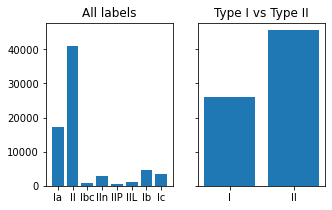

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(5,3), sharey=True)

# (labels, class names, figure title)
multi_tuple = (labels, ['Ia', 'II', 'Ibc', 'IIn', 'IIP', 'IIL', 'Ib', 'Ic'], 'All labels')
binar_tuple = (labels_new, ['I', 'II'], 'Type I vs Type II')

for index, (y_vector, cls_names, title) in enumerate([multi_tuple, binar_tuple]):
    values, counts = np.unique(y_vector, return_counts=True)
    x_range = np.arange(len(values))
    axes[index].bar(x_range,counts)
    axes[index].set_title(title)
    axes[index].set_xticks(x_range)
    axes[index].set_xticklabels(cls_names)
    
plt.show()

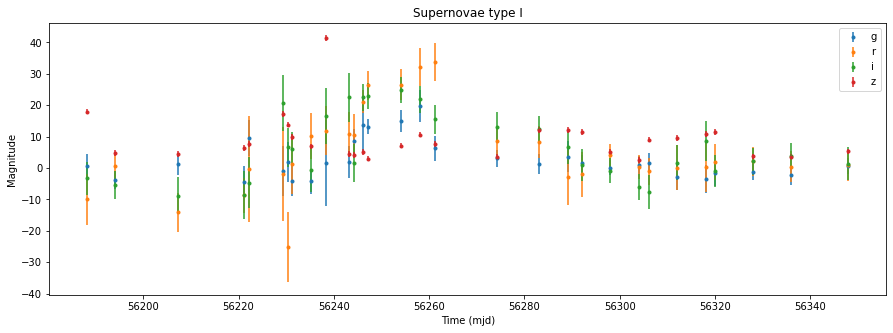

In [4]:
selected = light_curves[labels_new == 0][0]
plt.figure(figsize=(15,5))

for i, passband in enumerate(['g', 'r', 'i', 'z']):
    plt.errorbar(selected[:,0], 
                 selected[:,i+1], 
                 yerr=selected[:,i+5], 
                 label=passband, 
                 fmt='.')

plt.legend()
plt.xlabel('Time (mjd)')
plt.ylabel('Magnitude')
plt.title('Supernovae type I')
plt.show()


## Data preprocessing using tf.Data

In [5]:
INP_DIM = 9 # Number of attributes e.g., mjd, magnitudes, errors...
NUM_CLS = len(np.unique(labels_new))
BATCH_SIZE = 128 # Training batch size

In [6]:
def create_generator(list_of_arrays, labels):
    for i, j in zip(list_of_arrays, labels):
        yield {'lightcurve': i,
               'label'     : int(j),
               'mask'      : np.ones(i.shape[0])}

In [23]:
def standardize(light_curve):
    lc_means = tf.reduce_mean(light_curve, 0)
    lc_std   = tf.math.reduce_std(light_curve, 0)
#     return tf.math.divide_no_nan(light_curve - tf.expand_dims(lc_means, 0), lc_std)
    return light_curve-lc_means

def min_max_scaler(light_curve):
    lc_min   = tf.reduce_min(light_curve, 0)
    lc_max   = tf.reduce_max(light_curve, 0)
    return tf.math.divide_no_nan(light_curve - lc_min, lc_max-lc_min)

In [24]:
def preprocess(input_dict):
    light_curve = standardize(input_dict['lightcurve'])
    cat_label   = tf.one_hot(input_dict['label'], NUM_CLS)
    bool_mask   = tf.cast(input_dict['mask'], tf.bool)
    return (light_curve, bool_mask), cat_label

In [25]:
def load_class_dataset(lightcurves, labels):
    dataset = tf.data.Dataset.from_generator(lambda: create_generator(light_curves, labels),
                                             output_types= {'lightcurve':tf.float32,
                                                            'label':tf.int32,
                                                            'mask':tf.int32},
                                             output_shapes={'lightcurve':(None, INP_DIM),
                                                            'label':(),
                                                            'mask':(None)})
    return dataset

def create_dataset(light_curves, labels, balanced=False):
    if balanced:
        datasets = []
        for y in np.unique(labels):
            cls_samples = light_curves[labels==y]
            cls_labels  = labels[labels==y]
            datasets.append(load_class_dataset(cls_samples, cls_labels))
        dataset = tf.data.Dataset.sample_from_datasets(datasets)
    else:
        dataset = load_class_dataset(light_curves, labels)
        
    dataset = dataset.map(preprocess)
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True) # shuffling in chunks of 1000 objects 
    dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(([None, INP_DIM], [None]), [NUM_CLS]))
    return dataset

In [26]:
x_train, x_rest, \
y_train, y_rest = train_test_split(light_curves, labels_new, test_size=0.5, random_state=42)

x_val, x_test, \
y_val, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)

In [27]:
train_batches = create_dataset(x_train, y_train, balanced=True) 
valid_batches = create_dataset(x_val, y_val)
test_batches  = create_dataset(x_test, y_test)

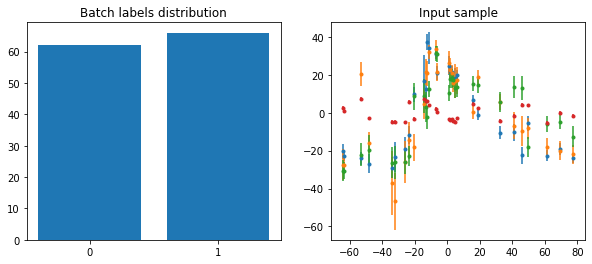

In [28]:
fig, axes  = plt.subplots(1, 2, figsize=(10,4))
for (x,m), y in train_batches:
    un, co = np.unique(tf.argmax(y, 1), return_counts=True)
    axes[0].bar(range(len(un)), co)
    axes[0].set_xticks(range(len(un)))
    axes[0].set_xticklabels(un)
    axes[0].set_title('Batch labels distribution')
    
    masked_sample = tf.boolean_mask(x[0], m[0])
    for i, passband in enumerate(['g', 'r', 'i', 'z']):
        axes[1].errorbar(masked_sample[:,0], 
                         masked_sample[:,i+1], 
                         yerr=selected[:,i+5], 
                         label=passband, 
                         fmt='.')
    axes[1].set_title('Input sample')
    break

## Long Short Term Memory

Using ```Sequential()``` class from *Keras Library* we can stack several layers. In this case, we will use recurrent and dense layer for *the middle learning* and dense activated layer for the output. Remember that the output should have the same dimension as number of classes are considered.<br><br>A graphical representation is shown bellow 

<img src="./img/archi.png" alt="Girl in a jacket" width="700" height="400"> 

In [29]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [34]:
# Params 
n_neurons    = 32  # Neurons in each gate of LSTM
dropout_prob = 0.3 # Fraction of the units to drop 
num_layers   = 2

In [36]:
lc_placeholder   = Input(shape=(None, INP_DIM), dtype=tf.float32)
mask_placeholder = Input(shape=(None,), dtype=tf.bool)
inputs = (lc_placeholder, mask_placeholder)

cells = []
for i in range(num_layers):
    x = LSTM(n_neurons, dropout=dropout_prob)

rnn_network = tf.keras.layers.RNN(cells)

x = rnn_network(inputs[0], mask=inputs[1])
predictions = Dense(NUM_CLS, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, 9)]    0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 rnn (RNN)                      (None, 9)            0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dense_2 (Dense)                (None, 2)            20          ['rnn[0][0]']              

In [37]:
history = model.fit(x=train_batches, 
                    epochs=5,
                    validation_data=valid_batches,
                    callbacks = [EarlyStopping(patience=5)])

Epoch 1/5
280/280 [==============================] - 6s 22ms/step - loss: 4.4744 - acc: 0.5948 - val_loss: 5.3388 - val_acc: 0.6197
Epoch 2/5
280/280 [==============================] - 6s 21ms/step - loss: 1.9482 - acc: 0.6089 - val_loss: 3.1197 - val_acc: 0.6296
Epoch 3/5
280/280 [==============================] - 6s 21ms/step - loss: 1.0177 - acc: 0.6227 - val_loss: 2.0670 - val_acc: 0.6319
Epoch 4/5
280/280 [==============================] - 6s 21ms/step - loss: 0.6719 - acc: 0.6324 - val_loss: 1.8179 - val_acc: 0.6327
Epoch 5/5
280/280 [==============================] - 6s 21ms/step - loss: 0.6152 - acc: 0.6325 - val_loss: 1.8169 - val_acc: 0.6327


In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_probas = model.predict(test_batches)
y_pred   = np.argmax(y_probas, axis=1)

y_test   = np.concatenate([y for _, y in test_batches], 0)
y_true   = np.argmax(y_test, axis=1)

acc_test = accuracy_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred, average='macro') 
print('Accuracy:{}\nF1:{}'.format(acc_test, f1_score))

Accuracy:0.6355615122577762
F1:0.3885891832832559


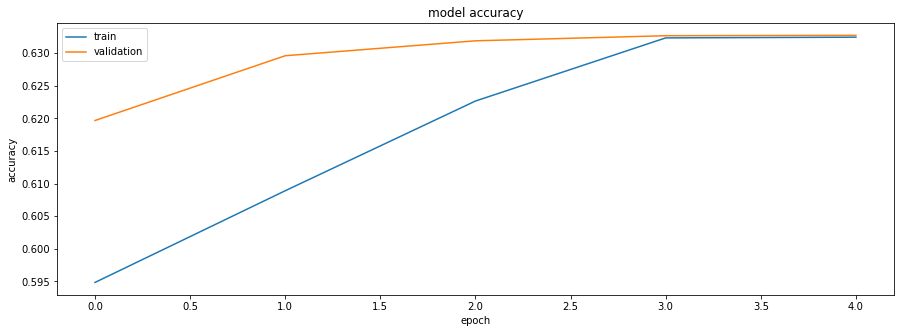

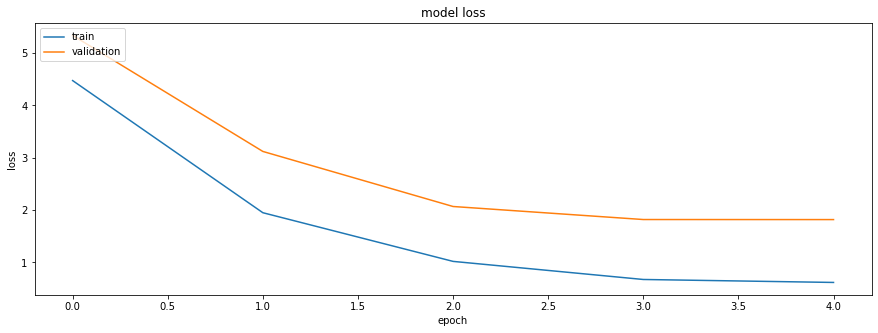

In [39]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

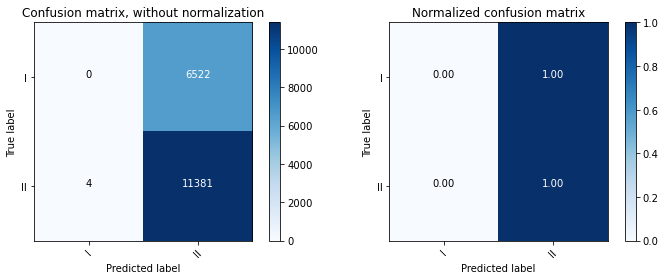

In [40]:
from sklearn.metrics import confusion_matrix
from visual import plot_confusion_matrix
class_names = ['I', 'II']
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')